# bat_data_processing

This ipynb performs the data processing for the battery data. The pkl files was read to get the raw data. Features based on voltage, capacity, and temperature are constructed for each cycle per cell and stores to a csv file.

## Import

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.optimize import curve_fit
from tqdm import tqdm

## Read data

Batch 1

In [2]:
batch1 = pickle.load(open(r'pickles/batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

Batch 2

In [3]:
batch2 = pickle.load(open(r'pickles/batch2.pkl','rb'))
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482]

In [4]:
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

Batch 3

In [5]:
batch3 = pickle.load(open(r'pickles/batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']
del batch3['b3c43']

Check

In [6]:
numBat1 = len(batch1.keys())
numBat2 = len(batch2.keys())
numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3
print(f"Batch 1: {numBat1} + Batch 2: {numBat2} + Batch 3: {numBat3}")
print(f"Total number of cells: {numBat}")

Batch 1: 41 + Batch 2: 43 + Batch 3: 40
Total number of cells: 124


In [7]:
bat_dict = {**batch1, **batch2, **batch3}

In [8]:
# Delete batch1, batch2, batch3 to free up memory
del batch1
del batch2
del batch3

## Data Exploration

### batch level

In [9]:
# cells
bat_dict.keys()

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c10', 'b2c11', 'b2c12', 'b2c13', 'b2c14', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c44', 'b2c45', 'b2c46', 'b2c47', 'b3c0', 'b3c1', 'b3c3', 'b3c4', 'b3c5', 'b3c6', 'b3c7', 'b3c8', 'b3c9', 'b3c10', 'b3c11', 'b3c12', 'b3c13', 'b3c14', 'b3c15', 'b3c16', 'b3c17', 'b3c18', 'b3c19', 'b3c20', 'b3c21', 'b3c22', 'b3c24', 'b3c25', 'b3c26', 'b3c27', 'b3c28', 'b3c29', 'b3c30

### cell level

In [10]:
# info within each cell
bat_dict['b1c0'].keys()

dict_keys(['cycle_life', 'charge_policy', 'summary', 'cycles'])

In [11]:
# cycle life
bat_dict['b1c0']['cycle_life']

array([[1852.]])

In [12]:
# charge policy
bat_dict['b1c0']['charge_policy']

'3.6C(80%)-3.6C'

In [13]:
# summary of the cell
bat_dict['b1c0']['summary']

{'IR': array([0.        , 0.01674235, 0.01672431, ..., 0.0181332 , 0.0181233 ,
        0.0181211 ]),
 'QC': array([0.        , 1.0710422 , 1.0716741 , ..., 0.88449496, 0.88432896,
        0.8840425 ]),
 'QD': array([0.        , 1.0706892 , 1.0719005 , ..., 0.88462406, 0.88433141,
        0.88280821]),
 'Tavg': array([ 0.        , 31.87501078, 31.93149033, ..., 32.70054223,
        32.99059246, 32.96182749]),
 'Tmin': array([ 0.      , 29.56613 , 29.604385, ..., 30.243074, 30.337559,
        30.634762]),
 'Tmax': array([ 0.      , 35.652016, 35.692978, ..., 36.786781, 36.923153,
        36.535774]),
 'chargetime': array([ 0.        , 13.34125   , 13.42577667, ..., 17.04515833,
        17.15257333, 17.35889667]),
 'cycle': array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.849e+03, 1.850e+03,
        1.851e+03])}

Text(0.5, 1.0, 'Discharge capacity over cycles')

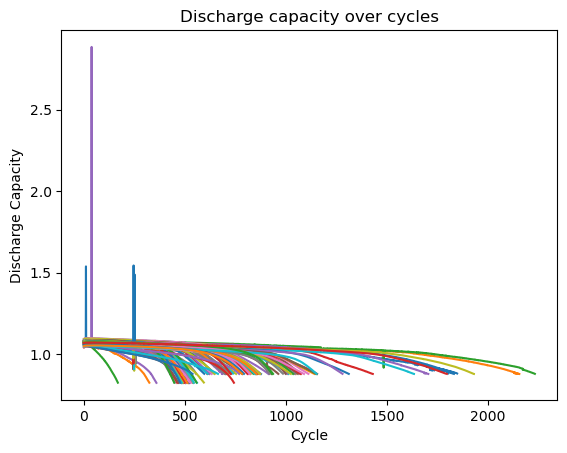

In [14]:
for cname in list(bat_dict.keys()):
    plt.plot(bat_dict[cname]['summary']['QD'][1:])

plt.xlabel("Cycle")
plt.ylabel("Discharge Capacity")
plt.title("Discharge capacity over cycles")

In [15]:
# cycle-wise info
# bat_dict['b1c0']['cycles']

### cycle level

In [16]:
bat_dict['b1c0']['cycles']['1'].keys()

dict_keys(['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't'])

## Feature Engineering for cell 1

### Voltage related features

Text(0.5, 1.0, 'dQdV change from cycle to cycle')

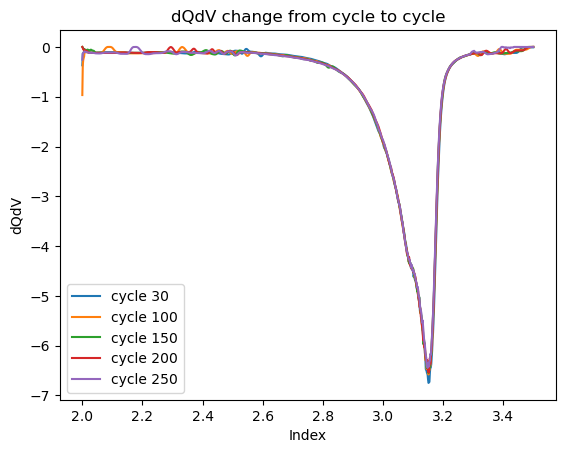

In [17]:
plt.plot(np.linspace(3.5, 2.0, num=1000), bat_dict['b1c0']['cycles']['30']['dQdV'])
plt.plot(np.linspace(3.5, 2.0, num=1000), bat_dict['b1c0']['cycles']['100']['dQdV'])
plt.plot(np.linspace(3.5, 2.0, num=1000), bat_dict['b1c0']['cycles']['150']['dQdV'])
plt.plot(np.linspace(3.5, 2.0, num=1000), bat_dict['b1c0']['cycles']['200']['dQdV'])
plt.plot(np.linspace(3.5, 2.0, num=1000), bat_dict['b1c0']['cycles']['250']['dQdV'])

plt.legend(["cycle 30", "cycle 100", "cycle 150", "cycle 200", "cycle 250"])
plt.xlabel("Index")
plt.ylabel("dQdV")
plt.title("dQdV change from cycle to cycle")

#### V1: Intensity decrease of IC peak from cycle I to J

In [18]:
i = "30"
js = ["100", "150", "200", "250"]
Vs = np.linspace(3.5, 2.0, num=1000)

In [19]:
for j in js:
    print(min(bat_dict['b1c0']['cycles'][j]['dQdV']) - min(bat_dict['b1c0']['cycles'][i]['dQdV']))

0.17018048576559774
0.1985535320872014
0.2060183604373691
0.3029209371388335


#### V2: Voltage shift of IC peak from cycle I to J

In [20]:
for j in js:
    print(Vs[np.argmin(bat_dict['b1c0']['cycles'][j]['dQdV'])] - Vs[np.argmin(bat_dict['b1c0']['cycles'][i]['dQdV'])])

0.0
0.0
0.0015015015015014122
-0.0030030030030028243


#### V3 ~ V8: $\Delta Q_{j-i}(V) = Q_j(V) - Q_i(V) $

Since the V in (V, Q) for each cycle might not be identical to carry out the substraction, interperlation should be applied to calculate $\Delta Q$ given the same V. Fortunately, the MIT team had created the feature, Qdlin, which is the linear interpolation of Q as a function of V, for the users. Therefore, we use Qdlin instead of Q to generate V3 to V8.

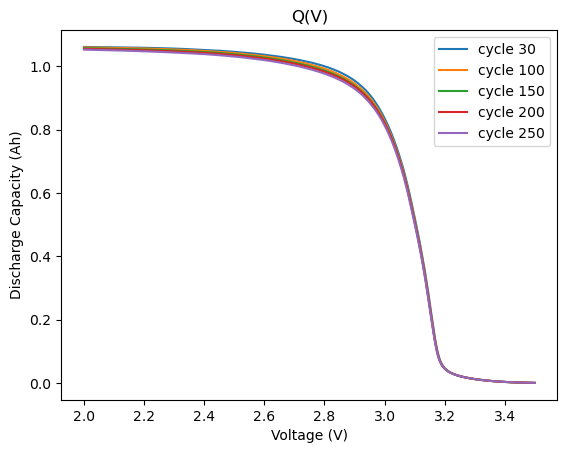

In [21]:
plt.plot(Vs, bat_dict['b1c0']['cycles']['30']['Qdlin'])
plt.plot(Vs, bat_dict['b1c0']['cycles']['100']['Qdlin'])
plt.plot(Vs, bat_dict['b1c0']['cycles']['150']['Qdlin'])
plt.plot(Vs, bat_dict['b1c0']['cycles']['200']['Qdlin'])
plt.plot(Vs, bat_dict['b1c0']['cycles']['250']['Qdlin'])

plt.xlabel("Voltage (V)")
plt.ylabel("Discharge Capacity (Ah)")
plt.title("Q(V)")
plt.legend(["cycle 30", "cycle 100", "cycle 150", "cycle 200", "cycle 250"])

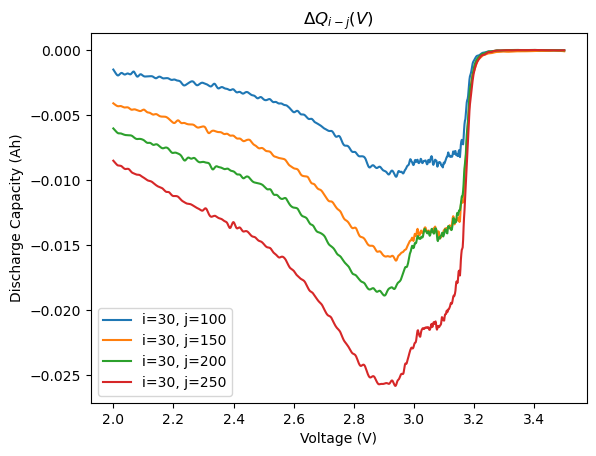

In [22]:
delta_q_30_100 = bat_dict['b1c0']['cycles']['100']['Qdlin'] - bat_dict['b1c0']['cycles']['30']['Qdlin']
delta_q_30_150 = bat_dict['b1c0']['cycles']['150']['Qdlin'] - bat_dict['b1c0']['cycles']['30']['Qdlin']
delta_q_30_200 = bat_dict['b1c0']['cycles']['200']['Qdlin'] - bat_dict['b1c0']['cycles']['30']['Qdlin']
delta_q_30_250 = bat_dict['b1c0']['cycles']['250']['Qdlin'] - bat_dict['b1c0']['cycles']['30']['Qdlin']

plt.plot(Vs, delta_q_30_100)
plt.plot(Vs, delta_q_30_150)
plt.plot(Vs, delta_q_30_200)
plt.plot(Vs, delta_q_30_250)

plt.xlabel("Voltage (V)")
plt.ylabel("Discharge Capacity (Ah)")
plt.title("$\Delta Q_{i-j}(V)$")
plt.legend(["i=30, j=100", "i=30, j=150", "i=30, j=200", "i=30, j=250"])

$min(\Delta Q_{i-j}(V))$

In [23]:
print(f"V3-1: {min(delta_q_30_100)}")
print(f"V3-2: {min(delta_q_30_150)}")
print(f"V3-3: {min(delta_q_30_200)}")
print(f"V3-4: {min(delta_q_30_250)}")

V3-1: -0.009733660782309417
V3-2: -0.016186514302654165
V3-3: -0.01887402355232659
V3-4: -0.025827440756881592


$max(\Delta Q_{i-j}(V))$

In [24]:
print(f"V4-1: {max(delta_q_30_100)}")
print(f"V4-2: {max(delta_q_30_150)}")
print(f"V4-3: {max(delta_q_30_200)}")
print(f"V4-4: {max(delta_q_30_250)}")

V4-1: -2.6418282268258304e-06
V4-2: -3.1549898733624325e-05
V4-3: 2.184491993908978e-05
V4-4: 1.5246882421534724e-05


$mean(\Delta Q_{i-j}(V))$

In [25]:
print(f"V5-1: {np.mean(delta_q_30_100)}")
print(f"V5-2: {np.mean(delta_q_30_150)}")
print(f"V5-3: {np.mean(delta_q_30_200)}")
print(f"V5-4: {np.mean(delta_q_30_250)}")

V5-1: -0.004113741476160885
V5-2: -0.007625862056934693
V5-3: -0.009428348953127023
V5-4: -0.01331970446705179


$Var(\Delta Q_{i-j}(V))$

In [26]:
print(f"V6-1: {np.var(delta_q_30_100)}")
print(f"V6-2: {np.var(delta_q_30_150)}")
print(f"V6-3: {np.var(delta_q_30_200)}")
print(f"V6-4: {np.var(delta_q_30_250)}")

V6-1: 1.0016874970398867e-05
V6-2: 2.6645119065613366e-05
V6-3: 3.4625761423173076e-05
V6-4: 6.843214565411747e-05


Skewness of $\Delta Q_{i-j}(V)$

In [27]:
print(f"V7-1: {skew(delta_q_30_100)}")
print(f"V7-2: {skew(delta_q_30_150)}")
print(f"V7-3: {skew(delta_q_30_200)}")
print(f"V7-4: {skew(delta_q_30_250)}")

V7-1: -0.3230140005732776
V7-2: -0.026485817909104908
V7-3: 0.28660745510341523
V7-4: 0.3263497849955203


Kurtosis of $\Delta Q_{i-j}(V)$

In [28]:
print(f"V8-1: {kurtosis(delta_q_30_100)}")
print(f"V8-2: {kurtosis(delta_q_30_150)}")
print(f"V8-3: {kurtosis(delta_q_30_200)}")
print(f"V8-4: {kurtosis(delta_q_30_250)}")

V8-1: -1.25028880036586
V8-2: -1.1847641306494776
V8-3: -0.9575035368626827
V8-4: -0.9917334064824619


### Capacity related features

$C_{k} = p_{1}*k + p_{2}$

In [29]:
# define the function
def linear_func(k, p1, p2):
    return p1 * k + p2

$C_{k} = p_{3}*\sqrt{k} + p_{4}$

In [30]:
# define the function
def sqrt_model(k, p3, p4):
    return p3 * np.sqrt(k) + p4

$C_{k} = p_{5}*p_{6}^k + p_{7}$

In [31]:
# define the function
def exp_model(k, p5, p6, p7):
    return p5 * (p6 ** k) + p7

Engineer capacity features

In [32]:
i = 30
js = [100, 150, 200, 250]

In [33]:
for j in js:
    print(f"From cycle {i} to cycle {j}...")
    
    # data
    k = np.linspace(i, j, num=j-i+1)
    c_k = bat_dict['b1c0']['summary']['QD'][i:j+1]
    
    # p1, p2
    popt, _ = curve_fit(linear_func, k, c_k)

    p1, p2 = popt
    print(f"p1: {p1}, p2: {p2}")
    
    # p3, p4
    popt, _ = curve_fit(sqrt_model, k, c_k)

    p3, p4 = popt
    print(f"p3: {p3}, p4: {p4}")
    
    # p5, p6, p7
    popt, _ = curve_fit(exp_model, k, c_k, p0=[1, 1.1, 0])  # Initial guess for p5, p6, p7

    p5, p6, p7 = popt
    print(f"p5: {p5}, p6: {p6}, p7: {p7}\n")

From cycle 30 to cycle 100...
p1: -1.3356199364489285e-05, p2: 1.07717997816917
p3: -0.00020478394274463504, p4: 1.077941032543745
p5: -9.131286288941294e-05, p6: 1.0259455865549965, p7: 1.0768637559772993

From cycle 30 to cycle 150...
p1: -2.3785342920801256e-05, p2: 1.0778448319064144
p3: -0.00041671401425094536, p4: 1.0795753159209374
p5: -0.00015467651395222555, p6: 1.0208623609607383, p7: 1.0769749031856548

From cycle 30 to cycle 200...
p1: -4.010082345518029e-05, p2: 1.0791175891834284
p3: -0.0007784373754389967, p4: 1.0826357879738757
p5: -0.0004125240905079732, p6: 1.0150466245754228, p7: 1.0774812942467225

From cycle 30 to cycle 250...
p1: -3.649209431782358e-05, p2: 1.0787911352859432
p3: -0.0007920265894368576, p4: 1.0827720058616315
p5: -0.013948834084194834, p6: 1.0019773566638202, p7: 1.0922213297627286



### Temperature related features

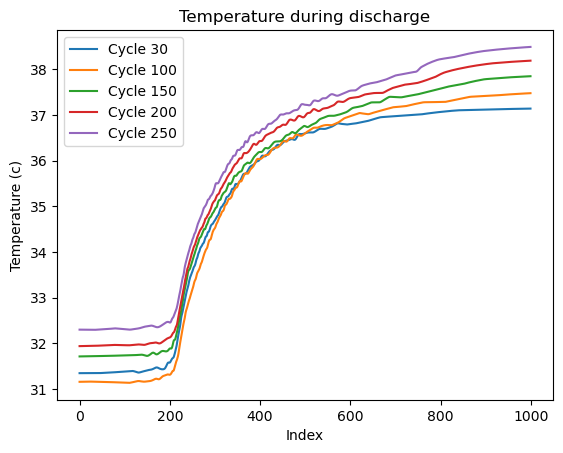

In [36]:
plt.plot(bat_dict['b3c11']['cycles']['30']['Tdlin'])
plt.plot(bat_dict['b3c11']['cycles']['100']['Tdlin'])
plt.plot(bat_dict['b3c11']['cycles']['150']['Tdlin'])
plt.plot(bat_dict['b3c11']['cycles']['200']['Tdlin'])
plt.plot(bat_dict['b3c11']['cycles']['250']['Tdlin'])

plt.xlabel("Index")
plt.ylabel("Temperature (c)")
plt.title("Temperature during discharge")
plt.legend(["Cycle 30", "Cycle 100", "Cycle 150", "Cycle 200", "Cycle 250"])

$\Delta(T_{i-j}) =  \sigma(T_{j}) - \sigma(T_{j})$, where $\sigma \in$ {mean, max, min}

T1: difference of the mean

In [56]:
print(f"T1-1: {np.mean(bat_dict['b1c0']['cycles']['100']['Tdlin']) - np.mean(bat_dict['b1c0']['cycles']['30']['Tdlin'])}")
print(f"T1-2: {np.mean(bat_dict['b1c0']['cycles']['150']['Tdlin']) - np.mean(bat_dict['b1c0']['cycles']['30']['Tdlin'])}")
print(f"T1-3: {np.mean(bat_dict['b1c0']['cycles']['200']['Tdlin']) - np.mean(bat_dict['b1c0']['cycles']['30']['Tdlin'])}")
print(f"T1-4: {np.mean(bat_dict['b1c0']['cycles']['250']['Tdlin']) - np.mean(bat_dict['b1c0']['cycles']['30']['Tdlin'])}")

T1-1: -0.010828039757889485
T1-2: -0.08538562944305994
T1-3: 0.21214632055291816
T1-4: -0.0012255471860100897


T2: difference of the maximum

In [57]:
print(f"T2-1: {np.max(bat_dict['b1c0']['cycles']['100']['Tdlin']) - np.max(bat_dict['b1c0']['cycles']['30']['Tdlin'])}")
print(f"T2-2: {np.max(bat_dict['b1c0']['cycles']['150']['Tdlin']) - np.max(bat_dict['b1c0']['cycles']['30']['Tdlin'])}")
print(f"T2-3: {np.max(bat_dict['b1c0']['cycles']['200']['Tdlin']) - np.max(bat_dict['b1c0']['cycles']['30']['Tdlin'])}")
print(f"T2-4: {np.max(bat_dict['b1c0']['cycles']['250']['Tdlin']) - np.max(bat_dict['b1c0']['cycles']['30']['Tdlin'])}")

T2-1: 0.09356854807177939
T2-2: 0.03250000454440283
T2-3: 0.4224811268065878
T2-4: 0.22159860285707822


T3: difference of the minimum

In [58]:
print(f"T3-1: {np.min(bat_dict['b1c0']['cycles']['100']['Tdlin']) - np.min(bat_dict['b1c0']['cycles']['30']['Tdlin'])}")
print(f"T3-2: {np.min(bat_dict['b1c0']['cycles']['150']['Tdlin']) - np.min(bat_dict['b1c0']['cycles']['30']['Tdlin'])}")
print(f"T3-3: {np.min(bat_dict['b1c0']['cycles']['200']['Tdlin']) - np.min(bat_dict['b1c0']['cycles']['30']['Tdlin'])}")
print(f"T3-4: {np.min(bat_dict['b1c0']['cycles']['250']['Tdlin']) - np.min(bat_dict['b1c0']['cycles']['30']['Tdlin'])}")

T3-1: -0.0865734032504335
T3-2: -0.23577641968605434
T3-3: 0.010528929416892652
T3-4: -0.05253603604502999


## Process all cells

In [195]:
cols = ["cell_id"]
for i in range(1, 19):
    for j in range(1, 5):
        cols.append(f"feature_{i}-{j}")
cols.append("cell_life")

In [196]:
df = pd.DataFrame(columns=cols)

In [197]:
# define the function
def linear_func(k, p1, p2):
    return p1 * k + p2

# define the function
def sqrt_model(k, p3, p4):
    return p3 * np.sqrt(k) + p4

# define the function
def exp_model(k, p5, p6, p7):
    return p5 * (p6 ** k) + p7

In [198]:
cell_idx = 0

for cell in tqdm(bat_dict.keys()):
    # this cell is an outlier since it has very short life
    if cell == "b2c1":
        df.loc[cell_idx] = np.nan
        df.loc[cell_idx, "cell_id"] = cell
        df.loc[cell_idx, "cell_life"] = bat_dict[cell]['cycle_life'][0][0]
        cell_idx += 1
        continue
    
    # cycle id and cell life
    df.loc[cell_idx, "cell_id"] = cell
    df.loc[cell_idx, "cell_life"] = bat_dict[cell]['cycle_life'][0][0]
    
    # voltage
    i = "30"
    js = ["100", "150", "200", "250"]
    Vs = np.linspace(3.5, 2.0, num=1000)
    
    # V1, V2
    for j in js:
        df.loc[cell_idx, f"feature_1-{js.index(j)+1}"] = min(bat_dict[cell]['cycles'][j]['dQdV']) - min(bat_dict[cell]['cycles'][i]['dQdV'])
        df.loc[cell_idx, f"feature_2-{js.index(j)+1}"] = Vs[np.argmin(bat_dict[cell]['cycles'][j]['dQdV'])] - Vs[np.argmin(bat_dict[cell]['cycles'][i]['dQdV'])]
        
    # V3 ~ V8
    delta_q_30_100 = bat_dict[cell]['cycles']['100']['Qdlin'] - bat_dict[cell]['cycles']['30']['Qdlin']
    delta_q_30_150 = bat_dict[cell]['cycles']['150']['Qdlin'] - bat_dict[cell]['cycles']['30']['Qdlin']
    delta_q_30_200 = bat_dict[cell]['cycles']['200']['Qdlin'] - bat_dict[cell]['cycles']['30']['Qdlin']
    delta_q_30_250 = bat_dict[cell]['cycles']['250']['Qdlin'] - bat_dict[cell]['cycles']['30']['Qdlin']
    
    df.loc[cell_idx, f"feature_3-1"] = min(delta_q_30_100)
    df.loc[cell_idx, f"feature_3-2"] = min(delta_q_30_150)
    df.loc[cell_idx, f"feature_3-3"] = min(delta_q_30_200)
    df.loc[cell_idx, f"feature_3-4"] = min(delta_q_30_250)
    
    df.loc[cell_idx, f"feature_4-1"] = max(delta_q_30_100)
    df.loc[cell_idx, f"feature_4-2"] = max(delta_q_30_150)
    df.loc[cell_idx, f"feature_4-3"] = max(delta_q_30_200)
    df.loc[cell_idx, f"feature_4-4"] = max(delta_q_30_250)
    
    df.loc[cell_idx, f"feature_5-1"] = np.mean(delta_q_30_100)
    df.loc[cell_idx, f"feature_5-2"] = np.mean(delta_q_30_150)
    df.loc[cell_idx, f"feature_5-3"] = np.mean(delta_q_30_200)
    df.loc[cell_idx, f"feature_5-4"] = np.mean(delta_q_30_250)
    
    df.loc[cell_idx, f"feature_6-1"] = np.var(delta_q_30_100)
    df.loc[cell_idx, f"feature_6-2"] = np.var(delta_q_30_150)
    df.loc[cell_idx, f"feature_6-3"] = np.var(delta_q_30_200)
    df.loc[cell_idx, f"feature_6-4"] = np.var(delta_q_30_250)
    
    df.loc[cell_idx, f"feature_7-1"] = skew(delta_q_30_100)
    df.loc[cell_idx, f"feature_7-2"] = skew(delta_q_30_150)
    df.loc[cell_idx, f"feature_7-3"] = skew(delta_q_30_200)
    df.loc[cell_idx, f"feature_7-4"] = skew(delta_q_30_250)

    df.loc[cell_idx, f"feature_8-1"] = kurtosis(delta_q_30_100)
    df.loc[cell_idx, f"feature_8-2"] = kurtosis(delta_q_30_150)
    df.loc[cell_idx, f"feature_8-3"] = kurtosis(delta_q_30_200)
    df.loc[cell_idx, f"feature_8-4"] = kurtosis(delta_q_30_250)
    
    # capacity
    i = 30
    js = [100, 150, 200, 250]

    for j in js:
        # data
        k = np.linspace(i, j, num=j-i+1)
        c_k = bat_dict[cell]['summary']['QD'][i:j+1]

        # p1, p2
        popt, _ = curve_fit(linear_func, k, c_k)
        p1, p2 = popt

        # p3, p4
        popt, _ = curve_fit(sqrt_model, k, c_k)
        p3, p4 = popt

        # p5, p6, p7
        popt, _ = curve_fit(exp_model, k, c_k, p0=[1, 1.1, 0], maxfev = 6000)  # Initial guess for p5, p6, p7
        p5, p6, p7 = popt
        
        # store
        df.loc[cell_idx, f"feature_9-{js.index(j)+1}"] = p1
        df.loc[cell_idx, f"feature_10-{js.index(j)+1}"] = p2
        df.loc[cell_idx, f"feature_11-{js.index(j)+1}"] = p3
        df.loc[cell_idx, f"feature_12-{js.index(j)+1}"] = p4
        df.loc[cell_idx, f"feature_13-{js.index(j)+1}"] = p5
        df.loc[cell_idx, f"feature_14-{js.index(j)+1}"] = p6
        df.loc[cell_idx, f"feature_15-{js.index(j)+1}"] = p7
        
    # temperature
    df.loc[cell_idx, f"feature_16-1"] = np.mean(bat_dict[cell]['cycles']['100']['Tdlin']) - np.mean(bat_dict[cell]['cycles']['30']['Tdlin'])
    df.loc[cell_idx, f"feature_16-2"] = np.mean(bat_dict[cell]['cycles']['150']['Tdlin']) - np.mean(bat_dict[cell]['cycles']['30']['Tdlin'])
    df.loc[cell_idx, f"feature_16-3"] = np.mean(bat_dict[cell]['cycles']['200']['Tdlin']) - np.mean(bat_dict[cell]['cycles']['30']['Tdlin'])
    df.loc[cell_idx, f"feature_16-4"] = np.mean(bat_dict[cell]['cycles']['250']['Tdlin']) - np.mean(bat_dict[cell]['cycles']['30']['Tdlin'])
    
    df.loc[cell_idx, f"feature_17-1"] = np.max(bat_dict[cell]['cycles']['100']['Tdlin']) - np.max(bat_dict[cell]['cycles']['30']['Tdlin'])
    df.loc[cell_idx, f"feature_17-2"] = np.max(bat_dict[cell]['cycles']['150']['Tdlin']) - np.max(bat_dict[cell]['cycles']['30']['Tdlin'])
    df.loc[cell_idx, f"feature_17-3"] = np.max(bat_dict[cell]['cycles']['200']['Tdlin']) - np.max(bat_dict[cell]['cycles']['30']['Tdlin'])
    df.loc[cell_idx, f"feature_17-4"] = np.max(bat_dict[cell]['cycles']['250']['Tdlin']) - np.max(bat_dict[cell]['cycles']['30']['Tdlin'])
    
    df.loc[cell_idx, f"feature_18-1"] = np.min(bat_dict[cell]['cycles']['100']['Tdlin']) - np.min(bat_dict[cell]['cycles']['30']['Tdlin'])
    df.loc[cell_idx, f"feature_18-2"] = np.min(bat_dict[cell]['cycles']['150']['Tdlin']) - np.min(bat_dict[cell]['cycles']['30']['Tdlin'])
    df.loc[cell_idx, f"feature_18-3"] = np.min(bat_dict[cell]['cycles']['200']['Tdlin']) - np.min(bat_dict[cell]['cycles']['30']['Tdlin'])
    df.loc[cell_idx, f"feature_18-4"] = np.min(bat_dict[cell]['cycles']['250']['Tdlin']) - np.min(bat_dict[cell]['cycles']['30']['Tdlin'])
    
    cell_idx += 1

100%|█████████████████████████████████████████| 124/124 [00:01<00:00, 89.33it/s]


In [199]:
df

,cell_id,feature_1-1,feature_1-2,feature_1-3,feature_1-4,feature_2-1,feature_2-2,feature_2-3,feature_2-4,feature_3-1,...,feature_16-4,feature_17-1,feature_17-2,feature_17-3,feature_17-4,feature_18-1,feature_18-2,feature_18-3,feature_18-4,cell_life
0,b1c0,0.17018,0.198554,0.206018,0.302921,0.0,0.0,0.001502,-0.003003,-0.009734,...,-0.001226,0.093569,0.0325,0.422481,0.221599,-0.086573,-0.235776,0.010529,-0.052536,1852.0
1,b1c1,-0.318951,0.073244,-0.107269,-0.214021,0.0,0.003003,-0.003003,0.003003,-0.008012,...,0.294094,-0.015469,-0.016736,0.105243,0.368883,0.011073,-0.022966,0.206999,0.27144,2160.0
2,b1c2,-13.400116,0.064212,0.011109,0.056847,-1.153153,0.0,0.0,0.003003,-0.007951,...,0.374237,0.083732,-0.018544,0.209013,0.518433,0.007007,-0.081015,0.177867,0.213808,2237.0
3,b1c3,-0.04294,0.005751,0.01057,0.113304,-0.006006,0.0,-0.003003,0.001502,-0.013748,...,-0.197973,-0.191059,-0.22003,-0.208227,-0.270601,0.0872,-0.055179,0.007637,-0.041739,1434.0
4,b1c4,0.040659,0.123495,-0.049134,0.095473,0.003003,0.003003,-0.001502,0.001502,-0.011847,...,-0.050792,0.075951,-0.07816,0.044478,0.00548,0.024354,-0.101195,0.042406,-0.065277,1709.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,b3c39,-0.045965,0.160471,0.265957,0.260906,-0.003003,0.001502,0.004505,0.003003,-0.016426,...,0.933472,0.175283,0.532571,0.844672,1.102569,0.144779,0.192649,0.728113,0.978361,1156.0
120,b3c40,0.013568,0.070067,0.225559,0.342754,-0.003003,-0.001502,-0.001502,-0.001502,-0.020104,...,1.308985,0.633929,1.129286,1.379156,1.910471,-0.216712,0.356772,0.485147,0.886457,796.0
121,b3c41,0.141452,0.241174,0.339269,0.374774,-0.001502,0.0,-0.003003,-0.003003,-0.020988,...,0.849739,0.181009,0.748168,0.518888,1.217419,0.010371,0.458513,0.214895,0.854229,786.0
122,b3c44,0.116643,0.184333,0.272894,0.352578,0.001502,0.0,0.0,0.001502,-0.025134,...,0.816568,0.079039,0.731395,0.877101,1.219103,-0.235224,0.355573,0.501139,0.827045,940.0


split into train, prim test, secondary test

In [200]:
prim_test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
sec_test_ind = np.arange(numBat-numBat3,numBat)

train_df = df.iloc[train_ind, :]
prim_test_df = df.iloc[prim_test_ind, :]
sec_test_df = df.iloc[sec_test_ind, :]

## Export as .csv

In [203]:
# df.to_csv("all_data.csv", index=False)

# train_df.to_csv("training.csv", index=False)
# prim_test_df.to_csv("prim_test.csv", index=False)
# sec_test_df.to_csv("sec_test.csv", index=False)